In [110]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools
import os
import multiprocessing as mp
import json

import pandas as pd 
import numpy as np
import pymorphy2

import tokenize_uk as tok
import cld3
import pymorphy2
from stop_words import get_stop_words

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

import lightgbm

from gensim.models import Word2Vec

from sklearn.utils import resample, shuffle

import matplotlib.pyplot as plt

from common import *

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
%%time

df = pd.read_json('reviews.json')

df['text'] = df['text'].apply(lambda x: ' '.join(x))
# df['text'] = df['text'].apply(lambda x: str(x[0]))
df['lang'] = df['text'].apply(lambda x: cld3.get_language(x)[0])

data = df.query('lang in ("uk", "ru")')

def is_question(text): 
    return text.strip().endswith('?')        
data['is_question'] = data['text'].apply(lambda x: is_question(x))

data.groupby(['stars'])['text'].count()

CPU times: user 16.9 s, sys: 806 ms, total: 17.7 s
Wall time: 17.7 s


In [50]:
data.groupby(['stars'])['text'].count()

stars
1     2248
2     2248
3     4503
4    14407
5    40172
Name: text, dtype: int64

In [51]:
%%time

reg_happy = re.compile('(:|=|:-)?(\)+)')
reg_unhappy = re.compile('(:|=|:-)?(\(+)')

pure_numbers = re.compile('^[0-9].*$')

punct = """
"#$%&*+,./:;<=>@^`~…\\(\\)⟨⟩{}\[\|\]‒-–—―«»“”‘’'№
""".strip()

uk_sw = get_stop_words('uk')
ru_sw = get_stop_words('ru')


def replace_smiles(text): 
    new_text = re.sub(reg_happy, ' smile_happy ', text)
    new_text = re.sub(reg_unhappy, ' smile_unhappy ', new_text)
    return new_text


def delete_punctuation(tokens):
    return [t for t in tokens if t not in punct]


def lemmatize(df):
    uk_morph = pymorphy2.MorphAnalyzer(lang='uk')
    ru_morph = pymorphy2.MorphAnalyzer(lang='ru')
    
    def _lemma(tokens, lang): 
        if lang == 'uk': 
            morph = [uk_morph.parse(t)[0] for t in tokens]
        elif lang == 'ru': 
            morph = [ru_morph.parse(t)[0] for t in tokens]
        return morph
    
    df['morph'] = df[['tokens', 'lang']].apply(lambda x: _lemma(x['tokens'], x['lang']), axis=1)
    
    df['details'] = df['morph'].apply(lambda m: [{'original': x.word,
                                                  'lemma': x.normal_form, 
                                                  'pos_tag': str(x.tag.POS)} for x in m])
    del df['morph']
    return df


def delete_stop_words(details, lang): 
    if lang == 'uk': 
        return [t for t in details if t['lemma'] not in uk_sw]
    elif lang == 'ru': 
        return [t for t in details if t['lemma'] not in ru_sw]
    
    
def delete_pure_numbers(details): 
    return [t for t in details if not re.match(pure_numbers, t['lemma'])]

CPU times: user 50 µs, sys: 59 µs, total: 109 µs
Wall time: 114 µs


In [52]:
%%time

data['text_norm'] = data['text'].apply(lambda x: x.lower())  # capslock may possibly be useful

data['text_norm'] = data['text_norm'].apply(replace_smiles)
data['tokens'] = data['text_norm'].apply(tok.tokenize_words)
data['tokens'] = data['tokens'].apply(delete_punctuation)

data = parallelize(data, lemmatize)

#### Checkpoint dataset: 

In [53]:
data['details'] = data['details'].apply(json.dumps)
data.to_csv('preprocessed.csv', index=False)

#### Restore from checkpoint (this is done to make steps above faster):

In [157]:
data = pd.read_csv('preprocessed.csv')
data['details'] = data['details'].apply(json.loads)

In [ ]:
data['details'] = data[['details', 'lang']].apply(lambda x: delete_stop_words(x['details'], x['lang']), axis=1)
data['details'] = data['details'].apply(delete_pure_numbers)s

#### Splitting data into train and validation (aka holdout). Train will be later used for futher resampling and train/test spliting and model 
### Train BOW model on lemmatized data 

In [86]:
X, y = data['details'].values, data['stars'].values
partitioner = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=1234)
indexes = partitioner.split(X, y)
train_indexes, val_indexes = list(indexes)[0]

train_data, val_data = data.iloc[train_indexes], data.iloc[val_indexes]
train_data.groupby(['stars'])['text'].count()

stars
1     1953
2     1953
3     3946
4    12639
5    35373
Name: text, dtype: int64

In [98]:
#train_data = downsample(train_data)
# train_data = upsample(train_data)
train_data.groupby(['stars'])['text'].count()

stars
1     1953
2     1953
3     3946
4    12639
5    35373
Name: text, dtype: int64

In [87]:
X_val = val_data['details'].apply(lambda elems: [x['lemma'] for x in elems]).values
y_val = val_data['stars'].values

X = train_data['details'].apply(lambda elems: [x['lemma'] for x in elems]).values
y = train_data['stars'].values

In [88]:
vect = CountVectorizer(analyzer='word', ngram_range=(1, 2), max_df=0.99, min_df=0.001,
                           stop_words=None, lowercase=False, tokenizer=lambda doc: doc)
X_vec = vect.fit_transform(X)
X_val_vec = vect.transform(X_val)

##### Lets fit one model first to be able to compare with latest stacked model

In [89]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0,
    'class_weight': 'balanced'
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

scores = []
for train_idx, test_idx in skf.split(X, y): 
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    vect = CountVectorizer(analyzer='word', ngram_range=(1, 2), max_df=0.99, min_df=0.001,
                           stop_words=None, lowercase=False, tokenizer=lambda doc: doc)
    X_train = vect.fit_transform(X_train)
    
    clf = RandomForestClassifier(**rf_params)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(vect.transform(X_test).todense())
    
    scores.append(f1_score(y_test, y_pred, average='weighted'))
print('Cross-Val score:', sum(scores) / float(len(scores)))

clf = RandomForestClassifier(**rf_params)
clf.fit(X_vec, y)
y_pred =clf.predict(X_val_vec)
print('Single RF classifier F1 score', f1_score(y_val, y_pred, average='weighted'))

Cross-Val score: 0.5847592708449263
Single RF classifier F1 score 0.5864561978829382


In [111]:
%%time

x_train_, x_test_ = train_stacked_oof(X_vec, X_val_vec, y, y_val)

CPU times: user 1.11 s, sys: 986 ms, total: 2.09 s
Wall time: 6min 2s


In [112]:
clf = lightgbm.LGBMClassifier(boosting_type='gbdt', objective='multiclass', class_weight='balanced', 
                              n_estimators=500) 
clf.fit(x_train_, y)
y_pred = clf.predict(x_test_)

print('Stacked model F1 score', f1_score(y_val, y_pred, average='weighted'))

Stacked model F1 score 0.6290031179528566


In [113]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.32      0.49      0.39       345
          2       0.17      0.22      0.19       344
          3       0.21      0.31      0.25       696
          4       0.40      0.35      0.37      2231
          5       0.82      0.78      0.80      6243

avg / total       0.64      0.62      0.63      9859



[[ 170   65   48   27   35]
 [  84   75  108   51   26]
 [  79   88  215  198  116]
 [  84  115  344  778  910]
 [ 107   88  303  867 4878]]


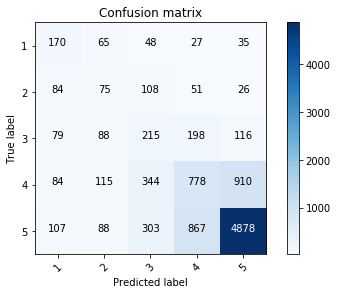

In [114]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3, 4, 5])

### Word vectors

In [115]:
data['text_norm'] = data['text'].apply(lambda x: x.lower())  # capslock may possibly be useful
data['text_norm'] = data['text_norm'].apply(replace_smiles)
data['tokens'] = data['text_norm'].apply(tok.tokenize_words)
data['tokens'] = data['tokens'].apply(delete_punctuation)

In [117]:
model = Word2Vec(data.tokens.values, size=100, window=5, min_count=5, workers=4)

In [118]:
model.wv.most_similar(positive=['три'])

[('два', 0.9438003301620483),
 ('четыре', 0.9182473421096802),
 ('1,5', 0.8800559043884277),
 ('полтора', 0.8795656561851501),
 ('1-1.5', 0.867458164691925),
 ('1.5', 0.8638948798179626),
 ('3-4', 0.8538327217102051),
 ('пол', 0.8440496325492859),
 ('2-3', 0.83775395154953),
 ('3-и', 0.8372681736946106)]

In [119]:
model.wv.most_similar(positive=['ужасный'])

[('отвратительный', 0.8773611783981323),
 ('ужасен', 0.8637514710426331),
 ('глухой', 0.8409662246704102),
 ('шикарен', 0.7988304495811462),
 ('слабый', 0.7516067028045654),
 ('отменный', 0.7466533184051514),
 ('плоский', 0.7453840970993042),
 ('посредственный', 0.7354903817176819),
 ('средний', 0.7326414585113525),
 ('встроенный', 0.7322560548782349)]

In [120]:
model.wv.most_similar(positive=['добре'])

[('гарно', 0.9548355340957642),
 ('чудово', 0.9451595544815063),
 ('якісно', 0.9214268922805786),
 ('швидко', 0.9114163517951965),
 ('чітко', 0.9100157022476196),
 ('відмінно', 0.9071762561798096),
 ('ідеально', 0.9043550491333008),
 ('подобається', 0.8931934833526611),
 ('тягне', 0.8880948424339294),
 ('робить', 0.8775618076324463)]

#### Word vectors give good results in terms of similarity, lets test it for classification!
The only caveat is it doesn't seem to capture between similarity of russian and ukrainian language

In [127]:
def get_vector(token): 
    try: 
        vec = model.wv[token]
    except KeyError:
        vec = np.zeros((100,))
    return vec

def get_vector_sum(tokens): 
    m = np.vstack([get_vector(t) for t in tokens])
    return np.mean(m, axis=0)

data['w2v'] = data['tokens'].apply(get_vector_sum)

In [128]:
X, y = data['w2v'], data['stars'].values
partitioner = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=1234)
indexes = partitioner.split(X, y)
train_indexes, val_indexes = list(indexes)[0]

train_data, val_data = data.iloc[train_indexes], data.iloc[val_indexes]
train_data.groupby(['stars'])['text'].count()

stars
1     1953
2     1953
3     3946
4    12639
5    35373
Name: text, dtype: int64

In [129]:
#train_data = downsamples(train_data)
train_data.groupby(['stars'])['text'].count()

stars
1     1953
2     1953
3     3946
4    12639
5    35373
Name: text, dtype: int64

In [130]:
X_val = np.vstack(val_data['w2v'].values)
y_val = val_data['stars'].values

X = np.vstack(train_data['w2v'].values)
y = train_data['stars'].values

In [134]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0,
    'class_weight': 'balanced'
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

scores = []
for train_idx, test_idx in skf.split(X, y): 
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    clf = RandomForestClassifier(**rf_params)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    scores.append(f1_score(y_test, y_pred, average='weighted'))
print('Cross-Val score:', sum(scores) / float(len(scores)))

clf = RandomForestClassifier(**rf_params)
clf.fit(X, y)
y_pred =clf.predict(X_val)
print('Single RF classifier F1 score', f1_score(y_val, y_pred, average='weighted'))

Cross-Val score: 0.5248404305957355
Single RF classifier F1 score 0.5220714251735697


In [135]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.15      0.61      0.23       345
          2       0.09      0.21      0.12       344
          3       0.14      0.27      0.18       696
          4       0.30      0.18      0.22      2231
          5       0.80      0.63      0.71      6243

avg / total       0.59      0.49      0.52      9859



[[ 209   42   34   19   41]
 [ 116   73   77   38   40]
 [ 147  142  188  114  105]
 [ 301  263  488  392  787]
 [ 664  332  551  764 3932]]


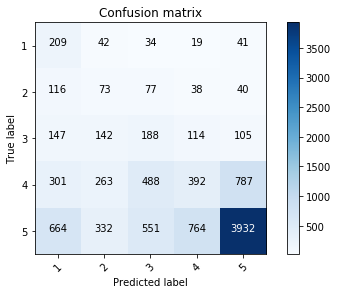

In [136]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3, 4, 5])

#### So looks like there is not much difference between 1, 2, 3 classes and 4, 5 classes (those are very often confused between each other).
I tried different settings of BOW and TF-IDF, trained word vectors, and maximum performace on validation set is ~63 percent with 5 classes (stacked model). 

Next steps to try - combine some classes


In [158]:
data['stars'] = data['stars'].apply(lambda x: 1 if x == 2 else x) # 1 and 2 become 1
data['stars'] = data['stars'].apply(lambda x: 2 if x == 3 else x) # 3 becomes 2
data['stars'] = data['stars'].apply(lambda x: 3 if x == 4 or x == 5 else x)  # 4 and 5 become 3

In [159]:
X, y = data['details'].values, data['stars'].values
partitioner = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=1234)
indexes = partitioner.split(X, y)
train_indexes, val_indexes = list(indexes)[0]

train_data, val_data = data.iloc[train_indexes], data.iloc[val_indexes]
train_data.groupby(['stars'])['text'].count()

stars
1     3906
2     3946
3    48012
Name: text, dtype: int64

In [160]:
X_val = val_data['details'].apply(lambda elems: [x['lemma'] for x in elems]).values
y_val = val_data['stars'].values

X = train_data['details'].apply(lambda elems: [x['lemma'] for x in elems]).values
y = train_data['stars'].values

In [161]:
vect = CountVectorizer(analyzer='word', ngram_range=(1, 2), max_df=0.99, min_df=0.001,
                           stop_words=None, lowercase=False, tokenizer=lambda doc: doc)
X_vec = vect.fit_transform(X)
X_val_vec = vect.transform(X_val)

In [162]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0,
    'class_weight': 'balanced'
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

scores = []
for train_idx, test_idx in skf.split(X, y): 
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    vect = CountVectorizer(analyzer='word', ngram_range=(1, 2), max_df=0.99, min_df=0.001,
                           stop_words=None, lowercase=False, tokenizer=lambda doc: doc)
    X_train = vect.fit_transform(X_train)
    
    clf = RandomForestClassifier(**rf_params)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(vect.transform(X_test).todense())
    
    scores.append(f1_score(y_test, y_pred, average='weighted'))
print('Cross-Val score:', sum(scores) / float(len(scores)))

clf = RandomForestClassifier(**rf_params)
clf.fit(X_vec, y)
y_pred =clf.predict(X_val_vec)
print('Single RF classifier F1 score', f1_score(y_val, y_pred, average='weighted'))

Cross-Val score: 0.7851310860257665
Single RF classifier F1 score 0.7877941616212495


In [163]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.35      0.58      0.44       689
          2       0.18      0.44      0.25       696
          3       0.95      0.78      0.86      8474

avg / total       0.86      0.75      0.79      9859



[[ 400  161  128]
 [ 190  309  197]
 [ 540 1294 6640]]


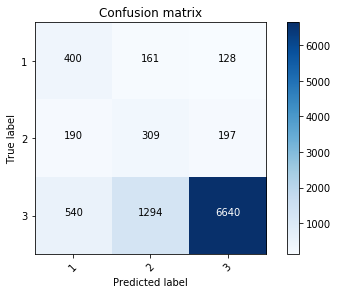

In [165]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3])

In [166]:
%%time

x_train_, x_test_ = train_stacked_oof(X_vec, X_val_vec, y, y_val)

CPU times: user 1.03 s, sys: 991 ms, total: 2.02 s
Wall time: 4min 9s


In [167]:
clf = lightgbm.LGBMClassifier(boosting_type='gbdt', objective='multiclass', class_weight='balanced', 
                              n_estimators=500) 
clf.fit(x_train_, y)
y_pred = clf.predict(x_test_)

print('Stacked model F1 score', f1_score(y_val, y_pred, average='weighted'))

Stacked model F1 score 0.8032840948930153


In [168]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.43      0.58      0.49       689
          2       0.18      0.51      0.27       696
          3       0.97      0.80      0.87      8474

avg / total       0.87      0.76      0.80      9859



[[ 403  207   79]
 [ 176  357  163]
 [ 361 1374 6739]]


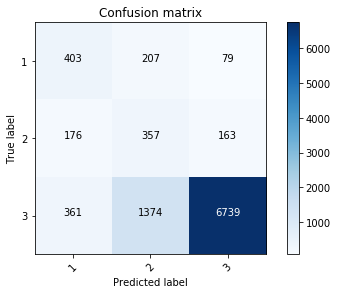

In [169]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3])

So model has difficulties trying to classify reviews with 3 stars - a lot of 4-5 stars reviews are confused with 3 stars and on the other hand 3 star reviews sometimes classified into 1 star review. 
I think people tend to use 4 stars for both - neutral reviews and positive reviews and 3 stars for neutral and negative. 
Also, as I mentioned, a lot of 5 star reviews don't express any sentiment but just ask neutral question.  